# Final project: Activity Recognition

The final assignment is to implement a classifier for activity recognition based on data from the phone’s sensors.

For this task, first the acceleration using the sensors of a phone was recorded. Then an HMM classifier, that should be able to discriminate between standing still, walking and running, was implemented and its functionality verified.

In [14]:
%reload_ext autoreload
%autoreload 2

from PattRecClasses import DiscreteD, GaussD, HMM, MarkovChain
from DataHandler import DataHandler
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd

### Data - Import and Pre-processing

In [15]:
# import

# Data for training
train = DataHandler('Train')
train_data = train.readFile()

train_stand = DataHandler('Stand')
train_stand_data = train_stand.readFile()
train_walk = DataHandler('Walk')
train_walk_data = train_walk.readFile()
train_run = DataHandler('Run')
train_run_data = train_run.readFile()


# Data for testing
test_stand = DataHandler('Stand2')
test_stand_data = test_stand.readFile()
test_stand2 = DataHandler('Stand3')
test_stand_data2 = test_stand2.readFile()
test_stand3 = DataHandler('Stand4')
test_stand_data3 = test_stand3.readFile()

test_walk = DataHandler('Walk2')
test_walk_data = test_walk.readFile()
test_walk2 = DataHandler('Walk3')
test_walk_data2 = test_walk2.readFile()
test_walk3 = DataHandler('Walk4')
test_walk_data3 = test_walk3.readFile()

test_run = DataHandler('Run2')
test_run_data = test_run.readFile()
test_run2 = DataHandler('Run3')
test_run_data2 = test_run2.readFile()
test_run3 = DataHandler('Run4')
test_run_data3 = test_run3.readFile()

### Characterise output distributions

In [17]:
# g1 - standing
mean_stand = np.mean(train_stand_data, axis = 0)
centered_data = train_stand_data - mean_stand
cov_stand = np.dot(centered_data.T, centered_data) / (len(train_stand_data) - 1)

# g2 - walking
mean_walk = np.mean(train_walk_data, axis = 0)
centered_data = train_walk_data - mean_walk
cov_walk = np.dot(centered_data.T, centered_data) / (len(train_walk_data) - 1)

# g3 - running
mean_run = np.mean(train_run_data, axis = 0)
centered_data = train_run_data - mean_run
cov_run = np.dot(centered_data.T, centered_data) / (len(train_run_data) - 1)

### Create and initialize HMM

In [18]:
# infinite HMM, with three states: standing (S1), walking (S2), running (S3)

q = np.array([1/3, 1/3, 1/3])
A  = np.array([[0.9, 0.05, 0.05], [0.05, 0.9, 0.05], [0.05, 0.05, 0.9]])
mc = MarkovChain(q, A) 

g1 = GaussD(means=mean_stand, cov = cov_stand)  # Distribution for state 'standing'
g2 = GaussD(means=mean_walk, cov = cov_walk)    # Distribution for state 'walking'
g3 = GaussD(means=mean_run, cov = cov_run)      # Distribution for state 'running'
h  = HMM(mc, [g1, g2, g3])                      # The HMM

### Train HMM

In [ ]:
h.train(train)

# set q back to equal probabilities
h.stateGen.q = np.array([1/3, 1/3, 1/3])

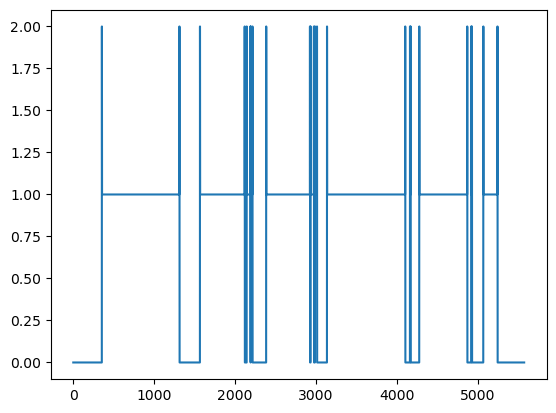

In [8]:
test = h.viterbi(test)

plt.plot(test)

### Verify HMM